In [24]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from astropy.time import Time
import matplotlib.pyplot as plt
import h5py
import re
from mc3.stats import time_avg

In [25]:
# define a few functions 
# Adapted from SPCA pipeline

text_objects = []
def create_subplot_names(rows, cols, rowslabel=None, minflux=None, maxflux=None):
    # Create a dictionary to store subplot axes and their names
    subplot_names = {}

    # Create subplots with increased spacing
    fig, axes = plt.subplots(nrows=len(rows), ncols=len(cols), sharex=True, sharey=True, figsize=(30, len(rows) * 4))

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # Adjust the values as needed
    if minflux is not None and maxflux is not None:
        plt.ylim(minflux, maxflux)

    # Iterate through rows and columns to name the subplots
    for i, row in enumerate(rows):
        for j, col in enumerate(cols):
            subplot_name = f"{col}_{row}"  # Switched order to col_row
            ax = axes[i, j]
            subplot_names[subplot_name] = ax

            # Set the title in the middle of each subplot
            # ax.set_title(subplot_name, fontsize=15, x=0.5, y=0.5, loc="center")  # Adjust the fontsize as needed

            # Set row names as labels for y axes for the first column
            if j == 0:
                if rowslabel==None:
                    ax.set_ylabel(row, fontsize=20, labelpad=20)  # Row name as y-axis label
                else:
                    ax.set_ylabel(rowslabel[i], fontsize=20, labelpad=20)  # Row name as y-axis label
            
            # Add "No Model" text to each subplot
            text_obj = ax.text(0.5, 0.45, 'No Model', transform=ax.transAxes,
                             fontsize=18, color='grey', ha='center', va='bottom')  #, bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
            text_objects.append(text_obj)

    # Set column names at the top of the subplot (not as titles)
    for j, col in enumerate(cols):
        ax = axes[0, j]  # Access the top row of subplots
        ax.xaxis.set_label_position('top')  # Move the x-axis label to the top
        ax.set_xlabel(col, fontsize=20, labelpad=20)  # Column name as x-axis label

    return fig, subplot_names

def calculate_delta_bic(bic_values_dict):
# Get the list of BIC values

    min_bic_key = min(bic_values_dict, key=lambda k: bic_values_dict[k])

    bic_values = list(bic_values_dict.values())
    min_bic = min(bic_values) # Find the minimum BIC value

    # Calculate delta BIC by subtracting the minimum BIC from each BIC value
    delta_bic_values = [bic - min_bic for bic in bic_values]

    # Create a dictionary that maps subplot names to their delta BIC values
    delta_bic_dict = {subplot_name: delta_bic for subplot_name, delta_bic in zip(bic_values_dict.keys(), delta_bic_values)}

    return delta_bic_dict, min_bic_key

def colormap(color=None):
    if color == "rosybrown":
        cmap = LinearSegmentedColormap.from_list('custom_rosybrown', [(0.737, 0.561, 0.561, 0.7), (0.737, 0.561, 0.561, 0)], N=256)
    elif color == "mintgreen":
        cmap = LinearSegmentedColormap.from_list('custom_mintgreen', [(0.678, 0.902, 0.749, 0.8), (0.678, 0.902, 0.749, 0)], N=256)
    elif color == "peach":
        cmap = LinearSegmentedColormap.from_list('custom_peach', [(0.976, 0.729, 0.651, 0.7), (0.976, 0.729, 0.651, 0)], N=256)
    elif color == "macaron_blue":
        cmap = LinearSegmentedColormap.from_list('custom_macaron_blue', [(0.482, 0.686, 0.937, 0.7), (0.482, 0.686, 0.937, 0)], N=256)
    elif color == "amber_orange":
        cmap = LinearSegmentedColormap.from_list('custom_amber_orange', [(1.0, 0.749, 0.0, 0.7), (1.0, 0.749, 0.0, 0)], N=256)
    elif color == "crimson_red":
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.7), (0.863, 0.078, 0.235, 0)], N=256)
    elif color == "dark_teal":
        cmap = LinearSegmentedColormap.from_list('custom_dark_teal', [(0.0, 0.204, 0.204, 0.5), (0.0, 0.204, 0.204, 0)], N=256)
    elif color == "terracotta":
        cmap = LinearSegmentedColormap.from_list('custom_terracotta', [(0.796, 0.388, 0.286, 0.7), (0.796, 0.388, 0.286, 0)], N=256)
    elif color == "muted_lavender":
        cmap = LinearSegmentedColormap.from_list('custom_muted_lavender', [(0.655, 0.529, 0.714, 0.6), (0.655, 0.529, 0.714, 0)], N=256)
    elif color == "yellow":
        cmap = LinearSegmentedColormap.from_list('custom_yellow', [(243/255, 187/255, 70/255, 1.0), (243/255, 187/255, 70/255, 0)], N=256)
    else:
        cmap = LinearSegmentedColormap.from_list('custom_crimson_red', [(0.863, 0.078, 0.235, 0.6), (0.863, 0.078, 0.235, 0)], N=256)
    return cmap

def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

def assign_colors_to_bic(bic_values_dict):
    bic_values = list(bic_values_dict.values())

    cmap = colormap(color)

    # Normalize BIC values to [0, 1] for colormap
    norm = plt.Normalize(min(bic_values), max(bic_values))
    
    # Map BIC values to colors
    colors = cmap(norm(bic_values))
    
    # Create a dictionary that maps subplot names to their colors
    bic_colors_dict = {subplot_name: color for subplot_name, color in zip(bic_values_dict.keys(), colors)}
    
    return bic_colors_dict

def plot_model(x, flux, astro, detec, 
               axName=None, bic=None, t_s=None, fp=None,
               savepath='plots/', plotName='Combined_plot_e1.pdf', plotTrueAnomaly=False, nbin=None, background_colors=None, min_subplot=False):   
    
    if nbin is not None:
        x_binned, _ = binValues(x, x, nbin)
        calibrated_binned, calibrated_binned_err = binValues(flux / detec[2][2][2], x, nbin, assumeWhiteNoise=True)
        #residuals_binned, residuals_binned_err = binValues(flux / detec - astro, x, nbin, assumeWhiteNoise=True)
    
    # fig, axes = plt.subplots()
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    # axes.plot(x, flux / detec, '.', color='k', markersize=4, alpha=0.15)
    axes.plot(x, astro, color='k', linewidth=2, alpha=0.7, zorder=1)
    # add straight line 
    axes.axhline(y=1, ls='--', color='k', alpha=0.7, zorder=200)
    
    if nbin is not None:
        axes.plot(x_binned, calibrated_binned, '.', color='k', markersize=4, alpha=0.15, zorder=2)
    else:
        axes.plot(x, flux/detec, '.', color='k', markersize=4, alpha=0.15, zorder=2)

    fp, fp_errp, fp_errm = fp

    if bic is not None:
        axes.text(0.5, 0.82, r'$\Delta$BIC: {:.2f}'.format(bic), transform=axes.transAxes,
                  fontsize=16, ha='center', va='bottom', bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))
        axes.text(
            0.5, 0.64,
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}^{:.0f}_{:.0f}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${{:.0f}}^{{+{{:.0f}}}}_{{-{{:.0f}}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            #r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: {:.0f}^{{+{:.0f}}}_{{-{:.0f}}}$'.format(t_s, fp*1e6, fp_errp*1e6, fp_errm*1e6),
            r'$t_{{\mathrm{{s}}}}$: {:.4f}, fp: ${:.0f}_{{{:.0f}}}^{{+{:.0f}}}$'.format(t_s*60, fp*1e6, fp_errm*1e6, fp_errp*1e6),
            transform=axes.transAxes,
            fontsize=14,
            color='blue',
            ha='center',
            va='bottom',
        )
    axes.set_xticks([])
    axes.set_facecolor(background_colors)


    if min_subplot:
        pos = axes.get_position()
        # Bbox(x0=0.5678571428571428, y0=0.495, x1=0.6785714285714286, y1=0.6875)
   
        macaron_red = (0.929, 0.235, 0.443)
        goldenrod_yellow = (0.855, 0.647, 0.125)  # RGB values

        for spine in axes.spines.values():
            spine.set_edgecolor(macaron_red)  # Set the border color to red
            spine.set_linewidth(5)  # Set the border linewidth
            spine.set_zorder(100)

    if savepath is not None:
        plt.savefig(savepath + plotName, bbox_inches='tight')


    return axes # x, astro, x_binned, calibrated_binned

def plot_rednoise(residuals, minbins, occDuration = None, fname=None, fontsize=10, axName=None,):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    axes = subplot_dict[axName]

    for text_obj in text_objects:
        if text_obj in axes.texts:
            text_obj.remove()

    print('Mode {} plotted'.format(axName))

    axes.set_yscale('log')
    axes.set_xscale('log')
    axes.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="k-", ecolor='0.5', capsize=0, label="Data RMS")
    axes.plot(binsz, stderr, c='darkorange', label="Gaussian std.")
    axes.vlines(occDuration, 1e-5, 1e-1, color='black', ls='-.', alpha=0.6, label='Occ. duration')
    ylim = axes.get_ylim()
    # ax.plot([ingrDuration,ingrDuration],ylim, color='black', ls='--', alpha=0.6)
    if occDuration is not None:
        axes.plot([occDuration,occDuration],ylim, color='black', ls='-.', alpha=0.6)
    axes.set_ylim(ylim)
    
    axes.xaxis.set_tick_params(labelsize=fontsize)
    axes.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.legend(loc='best', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    return axes

def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters[e]
    params.t0 = 58388.7939*24
    params.per = 3.777940*24              #orbital period in hours
    params.rp = 0.0539                    #planet radius (in units of stellar radii) # check that this is ratio of radii -> 0.0539 is charles value
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def exponential_func(x, a, b, c):
    return a * np.exp(-b * x) + c

def linear_slope(time, m, b):
    return m*time + b

def poly_3rd_degree(t, a, b, c, d):
    return a * t**3 + b * t**2 + c * t + d

def double_exponential(time, c1, c2, c3, c4):
    return c1 * np.exp(-c2 * time) + c3 * np.exp(-c4 * time)

def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def detec_model(time, theta, model_type):
    detec = []
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*linear_slope(time, c4, c5)
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
        detec = exponential_func(time, c1, c2, c3)
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
        detec = linear_slope(time, c1, c2)
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = poly_3rd_degree(time, c1, c2, c3, c4)
    elif model_type == 'double_exp':
        t_s, fp, c1, c2, c3, c4, sigF = theta
        detec = double_exponential(time, c1, c2, c3, c4)
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
        detec = exponential_func(time, c1, c2, c3)*poly_3rd_degree(time, c4, c5, c6, c7)
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
        detec = linear_slope(time, c1, c2)*poly_3rd_degree(time, c3, c4, c5, c6)
    return detec

def signal(time, theta, model_type):
    if model_type == 'exp+linear':
        t_s, fp, c1, c2, c3, c4, c5, sigF = theta
    elif model_type == 'exp':
        t_s, fp, c1, c2, c3, sigF = theta
    elif model_type == 'linear':
        t_s, fp, c1, c2, sigF = theta
    elif model_type == 'polynomial':
        t_s, fp, c1, c2, c3, c4, sigF = theta
    elif model_type == 'exp+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, c7, sigF = theta
    elif model_type == 'linear+polynomial':
        t_s, fp, c1, c2, c3, c4, c5, c6, sigF = theta
    astro = transit_model(time, t_s, fp)
    detec = detec_model(time, theta, model_type)
    return astro*detec


In [26]:
# eclipses = ['1', '2', '3']
# a = '5'
# #aperture = ['4', '7', '12']
# segments = ['0000', '0001', '0002', '0003', '0004']

# # Initialize dictionaries to hold arrays for each aperture
# time_arr = {e: [] for e in eclipses}
# aplev_arr = {e: [] for e in eclipses}
# aperr_arr = {e: [] for e in eclipses}
# centroid_x_arr = {e: [] for e in eclipses}
# centroid_y_arr = {e: [] for e in eclipses}

# ndiscard = 0

# for e in eclipses:
#     for seg in segments:
#         if e == '1':
#             path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
#         elif e == '2':
#             path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-07-22_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
#         elif e == '3':
#             path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse'+ e +'/Stage3/S3_2024-08-05_lhs1140c_run1/ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'

#         with h5py.File(path, 'r') as file:     # open the file
#             time_arr[e] = np.append(time_arr[e], np.array(file['time']))
#             aplev_arr[e] = np.append(aplev_arr[e], np.array(file['aplev']))
#             aperr_arr[e] = np.append(aperr_arr[e], np.array(file['aperr']))
#             centroid_x_arr[e] = np.append(centroid_x_arr[e], np.array(file['centroid_x']))
#             centroid_y_arr[e] = np.append(centroid_y_arr[e], np.array(file['centroid_y']))

#     time_arr[e] = np.array(time_arr[e])
#     aplev_arr[e] = np.array(aplev_arr[e])
#     aperr_arr[e] = np.array(aperr_arr[e])
#     centroid_x_arr[e] = np.array(centroid_x_arr[e])
#     centroid_y_arr[e] = np.array(centroid_y_arr[e])

#     time_arr[e] = time_arr[e][ndiscard:]
#     aplev_arr[e] = aplev_arr[e][ndiscard:]
#     aperr_arr[e] = aperr_arr[e][ndiscard:]
#     centroid_x_arr[e] = centroid_x_arr[e][ndiscard:]
#     centroid_y_arr[e] = centroid_y_arr[e][ndiscard:]

# # eclipses
# ecl = {}
# ecl['1'] = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
# ecl['2']  = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
# ecl['3']  = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')

# for e in eclipses:
#     ecl[e] = ecl[e].mjd
#     ecl[e] = ecl[e]-time_arr[e][0]
#     ecl[e] = ecl[e]*24 # convert to hours
#     print(ecl[e])

# e_dur = 1.13 # hours

# print(time_arr['2'][0], time_arr['2'][-1])

# # Normalize time arrays to start at 0 for each eclipse in hours
# for e in eclipses:
#     time_arr[e] = (time_arr[e] - time_arr[e][0])*24 
# 60275.77672542595

In [27]:
# load sigma clipped arrays
aplev_arr= {}
time_arr= {}
aperr_arr= {}
centroid_x_arr= {}
centroid_y_arr= {}

path = '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis/MIRI_Eclipse_Photometry_Analysis/ModelComparison/Fortune_joint_results/Clipped_arrays/'

eclipses = ['1', '2', '3']


for e in eclipses:
    aplev_arr[e] = np.load(path+f'aplev_arr_clipped_{e}.npy')
    time_arr[e] = np.load(path+f'time_arr_clipped_{e}.npy')
    aperr_arr[e] = np.load(path+f'aperr_arr_clipped_{e}.npy')
    centroid_x_arr[e] = np.load(path+f'centroid_x_arr_clipped_{e}.npy')
    centroid_y_arr[e] = np.load(path+f'centroid_y_arr_clipped_{e}.npy')

    time_arr[e] = np.array(time_arr[e])
    aplev_arr[e] = np.array(aplev_arr[e])
    aperr_arr[e] = np.array(aperr_arr[e])
    centroid_x_arr[e] = np.array(centroid_x_arr[e])
    centroid_y_arr[e] = np.array(centroid_y_arr[e])

    time_arr[e] = time_arr[e]
    aplev_arr[e] = aplev_arr[e]
    aperr_arr[e] = aperr_arr[e]
    centroid_x_arr[e] = centroid_x_arr[e]
    centroid_y_arr[e] = centroid_y_arr[e]

# eclipses
ecl = {}
ecl['1'] = Time('2023-11-27 21:00', format = 'iso', scale = 'tdb')
ecl['2']  = Time('2024-07-07 18:34', format = 'iso', scale = 'tdb')
ecl['3']  = Time('2024-07-19 02:34', format = 'iso', scale = 'tdb')

for e in eclipses:
    ecl[e] = ecl[e].mjd
    ecl[e] = ecl[e]-time_arr[e][0]
    ecl[e] = ecl[e]*24 # convert to hours
    print(ecl[e])

e_dur = 1.13 # hours

print(time_arr['2'][0], time_arr['2'][-1])

# Normalize time arrays to start at 0 for each eclipse in hours
for e in eclipses:
    time_arr[e] = (time_arr[e] - time_arr[e][0])*24 


2.358589777140878
2.368593581893947
2.2976226956234314
60498.67491971186 60498.83655425628


In [28]:
# bin the data
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))
    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr

# retrieve proper errorbars on aplev
def binFluxError(values, error, binAxisValues, nbin, assumeWhiteNoise=True):
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])
    binCounts = np.array([np.sum(digitized == i) for i in range(1, nbin)])

    binnedErr = np.array([np.mean(error[digitized == i]) for i in range(1, nbin)])/np.sqrt(binCounts)

    return binned, binnedErr

nbin = 77
bins_time = {e: [] for e in eclipses}
bins_time_err = {e: [] for e in eclipses}
bins_aplev = {e: [] for e in eclipses}
binErr_aplev = {e: [] for e in eclipses}

aperr_norm = {}
bins_aplev_err = {}
aplev_norm = {}
bin_aplev_err = {}
temp = {}

for i, e in enumerate(eclipses): 
    aperr_norm[e] = aperr_arr[e]/np.mean(aplev_arr[e])
    aplev_norm[e] = aplev_arr[e]/np.mean(aplev_arr[e])
    bins_time[e], temp = binValues(time_arr[e], time_arr[e], nbin)
    bins_aplev[e], temp = binValues(aplev_norm[e], time_arr[e], nbin)
    temp, bins_aplev_err[e] = binFluxError(aplev_norm[e], aperr_norm[e], time_arr[e], nbin)

## CHECK THIS



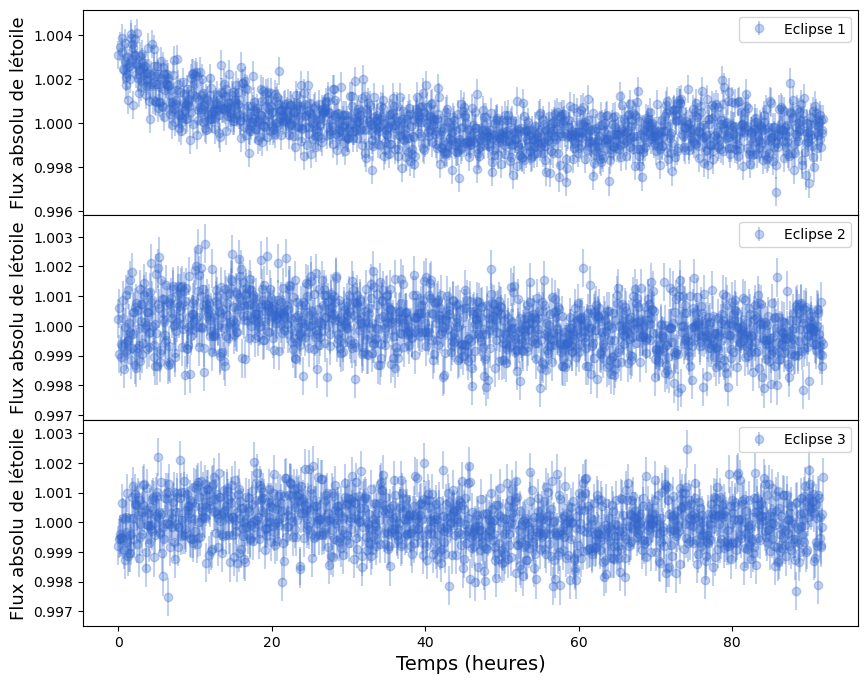

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
aperr_norm = {}
aplev_norm = {}
for i, e in enumerate(eclipses):
    aperr_norm[e] = aperr_arr[e]/np.mean(aplev_arr[e])
    aplev_norm[e] = aplev_arr[e]/np.mean(aplev_arr[e])
    ax[i].errorbar((time_arr[e]-time_arr[e][0])*24, aplev_norm[e], yerr=aperr_norm[e], fmt='o', label='Eclipse '+e, alpha=0.3, color='#3366cc')
    ax[i].set_ylabel('Flux absolu de l''étoile', fontsize=13)
    # make labelfont size bigger
    ax[i].legend()
ax[0].tick_params(labelbottom=False)
ax[1].tick_params(labelbottom=False)
ax[2].set_xlabel('Temps (heures)', fontsize=14)
plt.subplots_adjust(hspace=0)
#plt.tight_layout()
plt.show()

### FIGURE 1: Raw and detrended eclipses

In [30]:
# FOR JOINT FIT INSTEAD
def extract_mcmc_parameters(file_path):
    # Read the file content
    with open(file_path, "r") as file:
        data = file.read()
    
    # Extract key-value pairs using regular expressions
    results = re.findall(r'(\S+)\s*=\s*([-+]?\d*\.?\d+(?:[eE][-+]?\d+)?)\s*(\+\d*\.?\d+(?:[eE][-+]?\d+)?)?\s*(\-\d*\.?\d+(?:[eE][-+]?\d+)?)?', data)
    
    # Store results in a dictionary
    parameters = {}
    for result in results:
        key = result[0]
        value = float(result[1])
        plus_err = float(result[2]) if result[2] else None
        minus_err = float(result[3]) if result[3] else None
        parameters[key] = {
            "value": value,
            "plus_err": plus_err,
            "minus_err": minus_err
        }
    
    return parameters

astro = {e: {} for e in eclipses}
detec = {e: {} for e in eclipses}
residuals = {e: {} for e in eclipses}
bins_residuals = {e: [] for e in eclipses}


## CAN BE SAME OR DIFF MODELS FOR EACH ECL
# for e in eclipses:
#     for model in models:

# if instead of enumerating through the same models for each eclipse, assign a specific model per eclipse
models = ['exp_2nd_order_centroid', 'double_exp_2nd_order_centroid', 'linear_2nd_order_centroid'] #_2nd_order_centroid

#file = '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis/MIRI_Eclipse_Photometry_Analysis/ModelComparison/Final_Joint_Results/try6_longer_run4_results.txt'
file = '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis/MIRI_Eclipse_Photometry_Analysis/ModelComparison/Fortune_joint_results/try8_sigma_clipped_longer_run_2_results.txt'
parameters = extract_mcmc_parameters(file)

# unpack params
t_s, fp, e1_c1, e1_c2, e1_c3, e1_c4, e1_c5, e1_c6, e1_exp_c1, e1_exp_c2, e1_exp_c3, e2_c1, e2_c2, e2_c3, e2_c4, e2_c5, e2_c6, e2_dexp_c1, e2_dexp_c2, e2_dexp_c3, e2_dexp_c4,  e3_c1, e3_c2, e3_c3, e3_c4, e3_c5, e3_c6, e3_lin_c1, e3_lin_c2, sigF, RMS, chi2, BIC, RMS2  = [param['value'] for param in parameters.values()]

# eclipse #1
detec1 = detec_model_poly(centroid_x_arr['1'], centroid_y_arr['1'], e1_c1, e1_c2, e1_c3, e1_c4, e1_c5, e1_c6)
detec2 = exponential_func(time_arr['1'], e1_exp_c1, e1_exp_c2, e1_exp_c3) 
detec['1'] = detec1 * detec2

# eclipse #2
detec1 = detec_model_poly(centroid_x_arr['2'], centroid_y_arr['2'], e2_c1, e2_c2, e2_c3, e2_c4, e2_c5, e2_c6)
detec2 = double_exponential(time_arr['2'], e2_dexp_c1, e2_dexp_c2, e2_dexp_c3, e2_dexp_c4)
detec['2'] = detec1 * detec2

# eclipse #3 
detec1 = detec_model_poly(centroid_x_arr['3'], centroid_y_arr['3'], e3_c1, e3_c2, e3_c3, e3_c4, e3_c5, e3_c6)
#detec2 = exponential_func(time_arr['3'], e3_exp_c1, e3_exp_c2, e3_exp_c3)
detec2 = linear_slope(time_arr['3'], e3_lin_c1, e3_lin_c2)
detec['3'] = detec1 * detec2

for e in eclipses:
    astro[e] = transit_model(time_arr[e], t_s, fp)
    residuals[e]= (aplev_norm[e] / detec[e]) - astro[e]
    bins_residuals[e], temp = binValues(residuals[e], time_arr[e], nbin)


In [31]:
parameters['t_s']

{'value': 2.283794668231482,
 'plus_err': 0.014935039642042458,
 'minus_err': -0.01781966802279289}

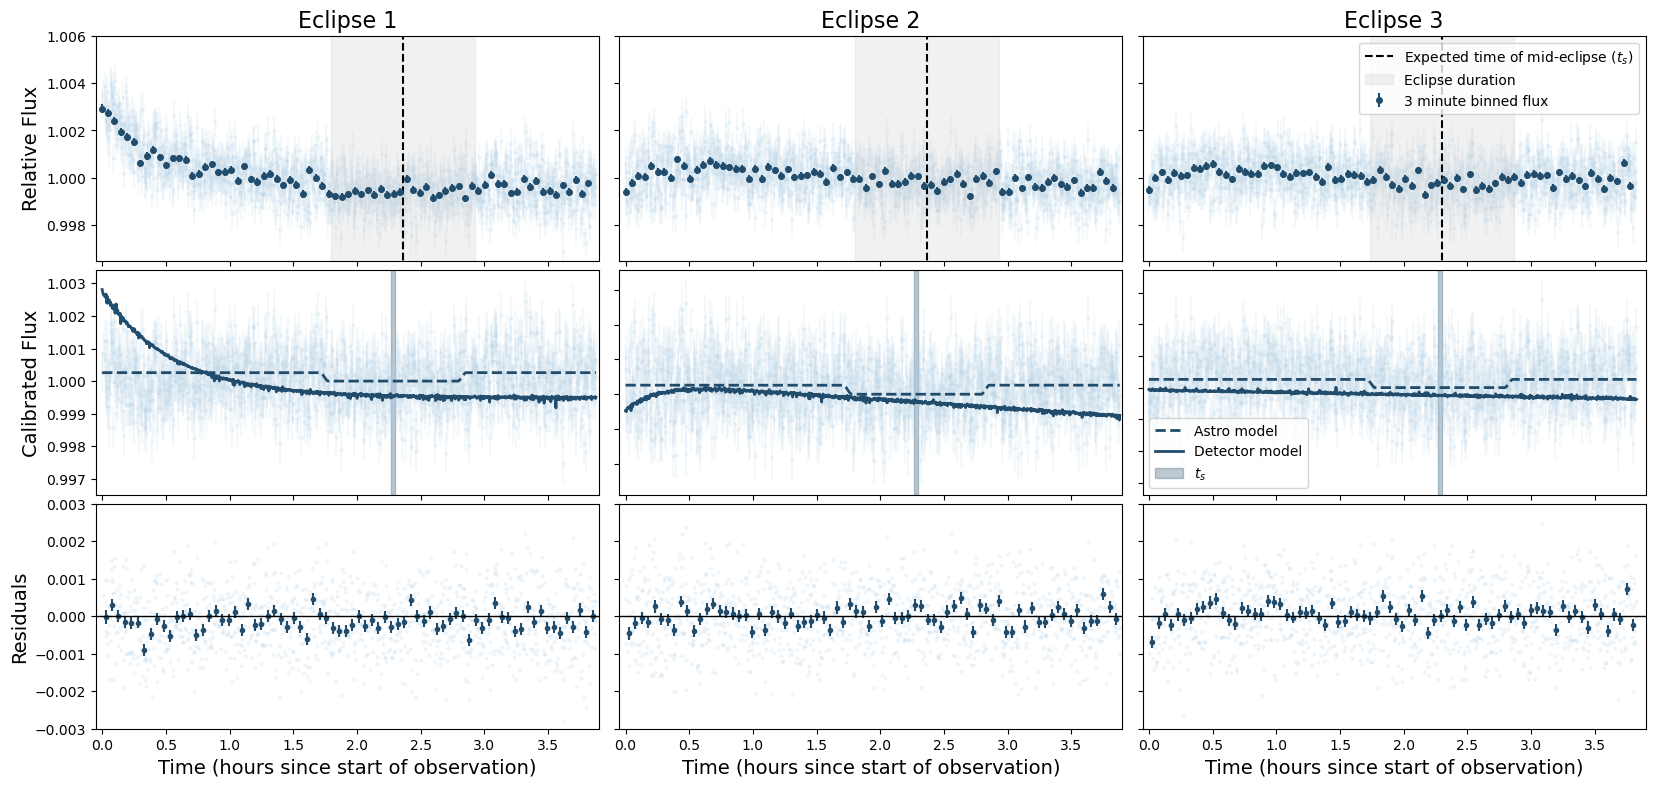

In [32]:
fig, ax = plt.subplots(3, 3, figsize=(20, 9),sharex=True)

for i, e in enumerate(eclipses):
    ax[0,i].errorbar(time_arr[e], aplev_norm[e], yerr=aperr_norm[e], fmt='o', alpha=0.15, color='#B1D0E7', markersize = 2, zorder=0)
    # error bar marker size
    ax[0,i].vlines(ecl[e], 0.99, 1.02, color='black', linestyle='--', label='Expected time of mid-eclipse $(t_s)$', zorder=3)
    ax[0,i].axvspan(ecl[e]-e_dur/2, ecl[e]+e_dur/2, color='lightgrey', alpha=0.3, label = 'Eclipse duration', zorder=1)
    ax[0,i].errorbar((bins_time[e]-bins_time[e][0]), bins_aplev[e], yerr=bins_aplev_err[e], fmt='o', color='#214C6C',markersize = 4, label='3 minute binned flux', zorder=5)

    ax[1,i].errorbar(time_arr[e], aplev_norm[e]/detec[e], yerr=aperr_norm[e], fmt='o', alpha=0.15, color='#B1D0E7', markersize = 2, zorder=2)
    ax[1,i].plot(time_arr[e], astro[e], '--', color='#214C6C', zorder=10, linewidth=2, label='Astro model')
    ax[1,i].plot(time_arr[e], detec[e], '-', color='#214C6C', zorder=5, linewidth=2, label='Detector model')
    #ax[1,i].vlines(t_s, 0.99, 1.02, color='black', linestyle='--', label='Expected time of mid-eclipse $(t_s)$', zorder=3)
    ax[1,i].axvspan((t_s+parameters['t_s']['minus_err']), (t_s+parameters['t_s']['plus_err']), color='#214C6C', alpha=0.3, label = r'$t_s$', zorder=1)
    #ax[3,i].errorbar(time_arr[e], residuals[e], yerr=aperr_norm[e]/detec[e], fmt='o', label='Residuals', alpha=0.15, color='#B1D0E7', markersize = 2, zorder=2)
    ax[2,i].plot(time_arr[e], residuals[e], 'o', label='Residuals', alpha=0.15, color='#B1D0E7', markersize = 2, zorder=2)
    ax[2,i].errorbar(bins_time[e], bins_residuals[e], yerr=bins_aplev_err[e], fmt='o', color='#214C6C', markersize=3, label='Binned residuals', zorder=5)
    ax[2,i].axhline(0, color='black', linestyle='-', linewidth=1, zorder=10)


# ax[1,0].plot(time_arr[e], aplev_norm[e], 'o', color='r', markersize=2)
# ax[1,0].plot(time_arr[e], aplev_norm[e]/detec[model], 'o', color='k', markersize=2)
#     #ax[i].errorbar(bins_time[e], bins_aplev[e], yerr=binErr_aplev[e], label='Binned data', color='black', linestyle='none', alpha=0.5, marker='o', zorder=1)

ax[0,0].set_ylabel('Relative Flux', fontsize=14)
ax[1,0].set_ylabel('Calibrated Flux', fontsize=14)
ax[2,0].set_ylabel('Residuals', fontsize=14)

# make labelfont size bigger

ax[1,2].legend()
ax[0,2].legend()
#ax[0,0].tick_params(labelbottom=False)
#ax[0,1].tick_params(labelbottom=False)

ax[0,0].set_ylim(0.9965, 1.006)
ax[0,1].set_ylim(0.9965, 1.006)
ax[0,2].set_ylim(0.9965, 1.006)

# ax[1,0].set_ylim(0.991, 1.016)
# ax[1,1].set_ylim(0.991, 1.016)
# ax[1,2].set_ylim(0.991, 1.016)

# ax[2,0].set_ylim(0.995, 1.005)
# ax[2,1].set_ylim(0.995, 1.005)
# ax[2,2].set_ylim(0.995, 1.005)

ax[2,0].set_ylim(-0.003, 0.003)
ax[2,1].set_ylim(-0.003, 0.003)
ax[2,2].set_ylim(-0.003, 0.003)

#hide y-ticks
ax[0,1].yaxis.set_ticklabels([])
ax[0,2].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[1,2].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[2,2].yaxis.set_ticklabels([])


ax[2,0].set_xlabel('Time (hours since start of observation)', fontsize=14)
ax[2,1].set_xlabel('Time (hours since start of observation)', fontsize=14)
ax[2,2].set_xlabel('Time (hours since start of observation)', fontsize=14)

ax[0,0].set_title('Eclipse 1', fontsize=16)
ax[0,1].set_title('Eclipse 2', fontsize=16)
ax[0,2].set_title('Eclipse 3', fontsize=16)

ax[0,1].set_xlim(-0.05, 3.9)


plt.subplots_adjust(hspace=0.04)
plt.subplots_adjust(wspace=0.04)


plt.savefig('../paper-figures/fig1_raw_eclipses-final.png')
plt.show()

(1.0, 3.4)

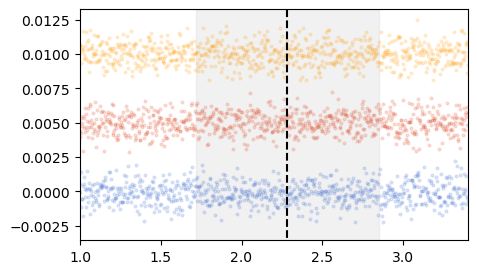

In [33]:
# check residuals to see if theres a reason behind t_s being greater for joint
c = ['#3366cc', '#dc3912', '#ff9900']
offset = [0, 0.005, 0.01]
plt.figure(figsize=(5, 3))
for i, e in enumerate(eclipses):
    plt.plot(time_arr[e]-time_arr[e][0], residuals[e]+offset[i], 'o', label='Residuals', alpha=0.15, color=c[i], markersize = 2, zorder=2)

ax = plt.gca()
ylim = ax.get_ylim()
plt.vlines(t_s, -0.005, 0.02, color='black', linestyle='--', label='Expected time of mid-eclipse $(t_s)$', zorder=3)
plt.axvspan(t_s-e_dur/2, t_s+e_dur/2, color='lightgrey', alpha=0.3, label = 'Eclipse duration', zorder=1)
plt.ylim(ylim)
plt.xlim(1.,3.4)

In [34]:
# duration of each observations 232.89768065675162 mins
232.89768065675162/3

77.6325602189172

### Appendix figure: Rednoise plot

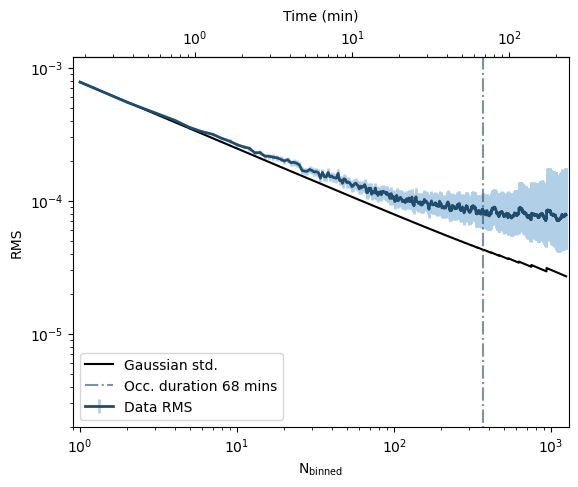

In [35]:
def plot_rednoise(residuals, minbins, occDuration = None, showPlot=True, fname=None, fontsize=10):
    
    maxbins = int(np.rint(residuals.size/minbins))
    
    try:
        rms, rmslo, rmshi, stderr, binsz = time_avg(residuals, maxbins)
    except:
        rms = []
        for i in range(minbins,len(residuals)):
            rms.append(helpers.binnedNoise(np.arange(len(residuals)),residuals,i))
        rms = np.array(rms)[::-1]

        binsz = len(residuals)/np.arange(minbins,len(residuals))[::-1]

        #In case there is a NaN or something while binning
        binsz = binsz[np.isfinite(rms)]
        rms = rms[np.isfinite(rms)]
        rmslo = np.zeros_like(rms)
        rmshi = rmslo
        stderr = np.std(residuals)/np.sqrt(binsz)
    
    plt.clf()
    ax = plt.gca()
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.errorbar(binsz, rms, yerr=[rmslo, rmshi], fmt="-", color='#214C6C', ecolor='#B1D0E7', capsize=0, linewidth=2, label="Data RMS")
    ax.plot(binsz, stderr, c='k', label="Gaussian std.")

    if occDuration is not None:
        ax.vlines(occDuration, 10e-7, 10e-2, color='#214C6C', ls='-.', alpha=0.6, label='Occ. duration 68 mins')
    ax.set_ylim(2e-6, 1.2e-3)
    ax.set_xlim(0.9, maxbins+50)

    # Add second x-axis on top showing time per bin
    cadence = 11.1  # seconds
    secax = ax.secondary_xaxis('top', functions=(lambda x: x * cadence / 60, lambda x: x * 60 / cadence))
    secax.tick_params(labelsize=fontsize)    
    
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    
    plt.xlabel(r'N$_{\rm binned}$', fontsize=fontsize)
    plt.ylabel('RMS', fontsize=fontsize)
    plt.title('Time (min)', fontsize=fontsize)
    plt.legend(loc='lower left', fontsize=fontsize)
    if fname is not None:
        plt.savefig(fname)

    if showPlot:
        plt.show()
    
    plt.close()

res = np.concatenate([residuals[e] for e in eclipses])
plot_rednoise(res, 3, fname='Joint_rednoise.png', occDuration=366.4864864864865)

In [36]:
np.std(res)*1e6

778.9375647389694

### Calculate some params


In [52]:
# Calculate weighted mean
models = ['exp_2nd_order_centroid', 'double_exp_2nd_order_centroid', 'linear_2nd_order_centroid'] 
eclipses = ['1', '2', '3']
params = ['1', '2', '3']

t_s_dict = {}
t_s_errp_dict = {}
t_s_errm_dict = {}

fp_dict =  {}
fp_errp_dict = {}
fp_errm_dict = {}

rms_dict = {}

weight_fp = []
weight_ts = []

fp_w = []
fp_weighted = []

t_s_w = []
t_s_weighted = []

for i in range(0, len(eclipses)):
    file = '/Volumes/HardDrive/MCMC_results/ecl'+ eclipses[i] +'_' + models[i] + '_results.txt'
    try:
        params[i] = extract_mcmc_parameters(file)
    except FileNotFoundError:
        file = '/Volumes/HardDrive/MCMC_results/ecl'+ eclipses[i] +'_' + models[i] + '_test_results.txt'
        params[i] = extract_mcmc_parameters(file)
    print(eclipses[i], params[i])
    t_s_dict[i], t_s_errp_dict[i], t_s_errm_dict[i], fp_dict[i], fp_errp_dict[i], fp_errm_dict[i], rms_dict[i] = params[i]['t_s']['value'], params[i]['t_s']['plus_err'], params[i]['t_s']['minus_err'], params[i]['fp']['value'], params[i]['fp']['plus_err'], params[i]['fp']['minus_err'], params[i]['RMS']['value']

    weight_fp.append(fp_errp_dict[i] + np.abs(fp_errm_dict[i]))
    fp_w.append(fp_dict[i])
    weight_ts.append((t_s_errp_dict[i] + np.abs(t_s_errm_dict[i]))*60)
    t_s_w.append((t_s_dict[i] - ecl[e])*60)


#weighted average of fp
weight_fp = np.array(weight_fp)
fp_w = np.array(fp_w)
fp_weighted_joint = np.sum(fp_w/(weight_fp**2))/np.sum(1/(weight_fp**2))

fp_weighted_joint = np.average(fp_w, weights=weight_fp)
fp_weighted_joint = np.array(fp_weighted_joint)

var_fp = ((np.sum(fp_w**2 * weight_fp)/np.sum(weight_fp)) - fp_weighted_joint**2)*(len(fp_w)/(len(fp_w)-1))  # unbiased variance
std_err_fp = np.sqrt(var_fp/len(fp_w))

print('Weighted average of fp is:', fp_weighted_joint*1e6, ' +/- ', std_err_fp*1e6, 'ppm')

#weighted average of t_s
weight_ts = np.array(weight_ts)
t_s_w = np.array(t_s_w)

t_s_weighted_joint = np.average(t_s_w, weights=weight_ts)
t_s_weighted_joint = np.array(t_s_weighted_joint)

t_s_var = ((np.sum(t_s_w**2 * weight_ts)/np.sum(weight_ts)) - t_s_weighted_joint**2)*(len(t_s_w)/(len(t_s_w)-1))  # unbiased variance
std_err_t_s = np.sqrt(t_s_var/len(t_s_w))

print('Weighted average of t_s:', t_s_weighted_joint, '+/-',std_err_t_s, 'minutes')

print('RMS is: ', rms_dict)

1 {'t_s': {'value': 2.3602571294799635, 'plus_err': 0.014040989133439208, 'minus_err': -0.01443463372059739}, 'fp': {'value': 0.00032468157819375113, 'plus_err': 6.262349329987012e-05, 'minus_err': -6.018895719224552e-05}, 'c_1': {'value': -14745.322362980303, 'plus_err': 69605.63556107617, 'minus_err': -83757.6784252982}, 'c_2': {'value': 83.99082615763945, 'plus_err': 832.8753553260962, 'minus_err': -770.6875726951649}, 'c_3': {'value': 149.8069213966778, 'plus_err': 540.4693513762916, 'minus_err': -493.5462191981656}, 'c_4': {'value': 0.4389031062024866, 'plus_err': 2.423258400188142, 'minus_err': -2.6460287511779494}, 'c_5': {'value': -1.550277507456328, 'plus_err': 2.9878264152214995, 'minus_err': -2.6962622876280924}, 'c_6': {'value': 0.18469852932209418, 'plus_err': 1.205043891499456, 'minus_err': -1.0623749361775454}, 'c_7': {'value': 0.003507165459710341, 'plus_err': 0.0002994428835371471, 'minus_err': -0.00027062152745477557}, 'c_8': {'value': 2.0629432259244855, 'plus_err': 

In [ ]:
# calculate brightness temps
def t_brightness(fp):
    h = 6.62607015e-34
    c = 299792458
    k = 1.380649e-23
    t_star = 3096
    t_depth = 2900
    l = 15e-6 # wavelength of observations

    return ((h * c) / (k * l)) * (np.log(1 + ((np.exp((h * c)/(l * k * t_star)) -1 )/(fp/t_depth)))) ** -1

# fp = 0.000259e6

# t_bright = t_brightness(fp)
# print(fp, t_bright)

In [53]:
# # Read the weighted mean results file that stores weighted mean of all models for each eclipse
weighted_mean_results_file = '/Users/alexandrarochon/Programming/LHS1140-Eureka/myAnalysis/MIRI_Eclipse_Photometry_Analysis/ModelComparison/MCMC_results/all_eclipses_weighted_mean_results.txt'

# Initialize dictionaries
fp_weighted = {}
fp_error = {}

t_s_weighted = {}
t_s_error = {}

with open(weighted_mean_results_file, "r") as file:
    lines = file.readlines()

i = 0
while i < len(lines):
    line = lines[i].strip()
    if line.startswith("Weighted mean"):
        eclipse_id = lines[i].strip().split()[-1][1:]  # Removes the 'E', keeps '1', '2', ...

        # Parse fp line
        fp_line = lines[i+1].strip().split()  # ['fp', '=', '357.3', '+/-', '13.5', 'ppm']
        fp_val = float(fp_line[2])
        fp_err = float(fp_line[4])

        # Parse t_s line
        ts_line = lines[i+2].strip().split()  # ['t_s', '=', '-0.09', '+/-', '0.12', 'minutes']
        ts_val = float(ts_line[2])
        ts_err = float(ts_line[4])

        # Store
        fp_weighted[eclipse_id] = fp_val
        fp_error[eclipse_id] = fp_err
        t_s_weighted[eclipse_id] = ts_val
        t_s_error[eclipse_id] = ts_err

        i += 3  # Skip to next block
    else:
        i += 1

for e in eclipses:
    print(f"Eclipse {e}: fp = {fp_weighted[e]} +/- {fp_error[e]} ppm, t_s = {t_s_weighted[e]} +/- {t_s_error[e]} minutes")


Eclipse 1: fp = 357.3254595160986 +/- 13.57139753521943 ppm, t_s = -0.09453235289854717 +/- 0.11980057362147242 minutes
Eclipse 2: fp = 209.1546046046781 +/- 13.136738059165175 ppm, t_s = -1.9968784848014862 +/- 0.4321573750326838 minutes
Eclipse 3: fp = 240.22522145124353 +/- 13.377403744264688 ppm, t_s = -2.2395720761647064 +/- 0.46279807242480453 minutes


In [58]:
def format_pm(val, errp, errm, precision=2, scale=1):
    """Format value with asymmetric errors for LaTeX."""
    if None in (val, errp, errm):
        return ''
    val_fmt = f"{val*scale:.{precision}f}"
    errp_fmt = f"{errp*scale:.{precision}f}"
    errm_fmt = f"{abs(errm)*scale:.{precision}f}"
    return f"${val_fmt}^{{+{errp_fmt}}}_{{-{errm_fmt}}}$"

def format_weight_err(val, err, precision=2, scale=1):
    """Format value with symmetric error for LaTeX."""
    if None in (val, err):
        return ''
    val_fmt = f"{val*scale:.{precision}f}"
    err_fmt = f"{err*scale:.{precision}f}"
    return f"${val_fmt} \\pm {err_fmt}$"

# Header
print("        & $fp$ (ppm) & $t_s$ (min) & $T_{B}$ (K) & RMS (ppm) & $fp$ (ppm) & $t_s$ (min) & $T_{B}$ (K) & RMS (ppm)\\\\")

# Per-eclipse rows
for i, e in enumerate(eclipses):
    # Best-fit
    #print(f"DEBUG: t_s = {t_s_dict[i]}, ecl = {ecl[e]}, delta = {(t_s_dict[i] - ecl[e]) * 60}")
    fp_str = format_pm(fp_dict[i], fp_errp_dict[i], fp_errm_dict[i], precision=0, scale=1e6)
    ts_str = format_pm((t_s_dict[i] - ecl[e]) * 60, t_s_errp_dict[i] * 60, t_s_errm_dict[i] * 60, precision=2)
    temp_str = f"{t_brightness(fp_dict[i]*1e6):.0f}"  
    rms_str = f"{rms_dict[i]:.0f}"
    weight_fp_str = format_weight_err(fp_weighted[e], fp_error[e], precision=0)
    weight_ts_str = format_weight_err(t_s_weighted[e], t_s_error[e], precision=2)

    # Weighted average (placeholder for now: add if available)
    fp_weight_str = ''
    ts_weight_str = ''
    T_weight_str = ''
    rms_weight_str = ''

    print(f"        E{i+1} best-fit & {fp_str} & {ts_str} & {temp_str} & {rms_str} & {fp_weight_str} & {ts_weight_str} & {T_weight_str} & {rms_weight_str} \\\\")
    print(f"        E{i+1} weighted average & {weight_fp_str} & {weight_ts_str} & - & - &  &  &  & \\\\")


# Joint fit row
joint_fp = parameters['fp']
joint_ts = parameters['t_s']
joint_rms = parameters['RMS']['value']

joint_fp_str = format_pm(joint_fp['value'], joint_fp['plus_err'], joint_fp['minus_err'], precision=0, scale=1e6)
joint_ts_str = format_pm((joint_ts['value'] - ecl['1']) * 60, joint_ts['plus_err'] * 60, joint_ts['minus_err'] * 60, precision=2)
joint_temp_str = f"{t_brightness(joint_fp['value'] * 1e6):.0f}"  
joint_rms_str = f"{joint_rms:.0f}"

print(f"        Joint best-fit & {joint_fp_str} & {joint_ts_str} & {joint_temp_str} & {joint_rms_str} & & & & \\\\")

# Weighted mean row (from all eclipses combined)
weighted_joint_fp_str = format_weight_err(fp_weighted_joint, std_err_fp, precision=0, scale=1e6)
weight_joint_ts_str = format_weight_err(t_s_weighted_joint, std_err_t_s, precision=2)

#weighted_temp_str = f"{t_brightness(* 1e6):.0f}"
print(f"        Joint weighted mean & {weighted_joint_fp_str} & {weight_joint_ts_str} & - & - & & & & \\\\")


        & $fp$ (ppm) & $t_s$ (min) & $T_{B}$ (K) & RMS (ppm) & $fp$ (ppm) & $t_s$ (min) & $T_{B}$ (K) & RMS (ppm)\\
        E1 best-fit & $325^{+63}_{-60}$ & $0.10^{+0.84}_{-0.87}$ & 664 & 808 &  &  &  &  \\
        E1 weighted average & $357 \pm 14$ & $-0.09 \pm 0.12$ & - & - &  &  &  & \\
        E2 best-fit & $182^{+66}_{-61}$ & $-1.53^{+1.03}_{-0.82}$ & 500 & 921 &  &  &  &  \\
        E2 weighted average & $209 \pm 13$ & $-2.00 \pm 0.43$ & - & - &  &  &  & \\
        E3 best-fit & $273^{+55}_{-55}$ & $-1.31^{+5.46}_{-1.95}$ & 607 & 824 &  &  &  &  \\
        E3 weighted average & $240 \pm 13$ & $-2.24 \pm 0.46$ & - & - &  &  &  & \\
        Joint best-fit & $259^{+31}_{-30}$ & $-4.49^{+0.90}_{-1.07}$ & 591 & 775 & & & & \\
        Joint weighted mean & $259 \pm 43$ & $0.16 \pm 1.52$ & - & - & & & & \\


In [17]:
# Print out individual best fits
print('t_s 1 = ',(2.3602571294799635 - ecl['1'])*60, '+/-', 0.014*60)

print('t_s 2 = ',(2.343142277292462 - ecl['2'])*60, '+', 0.017099657340541974 *60, '-', -0.01369810772783886*60)

print('t_s 3 = ',(2.275706171517549 - ecl['3'])*60, '+', 0.091*60, '-', 0.033*60)

print('t_s joint = ',(2.280973044206213 - ecl['1'])*60, '+', 0.01722640785860463*60, -0.0185464435603917*60)
print(ecl['1'], ecl['2'], ecl['3'])

t_s 1 =  0.10004114034511957 +/- 0.84
t_s 2 =  -1.5270782760890889 + 1.0259794404325184 - -0.8218864636703316
t_s 3 =  -1.3149914463529377 + 5.46 - 1.98
t_s joint =  -4.657003976079919 + 1.0335844715162779 -1.112786613623502
2.358589777140878 2.368593581893947 2.2976226956234314


In [18]:
# Convert Fortune et al. t_s results to mins
ecl = {}
ecl['1'] = Time('2023-11-27 21:00', format = 'iso', scale = 'utc')
ecl['2']  = Time('2024-07-07 18:34', format = 'iso', scale = 'utc')
ecl['3']  = Time('2024-07-19 02:34', format = 'iso', scale = 'utc')

fortune_ecl = {}
fortune_ecl['1'] = 0.3716
fortune_ecl['2'] = 223.2694
fortune_ecl['3'] = 234.6048

scale = 2460276-2400000.5 # convert from BJD to MJD (value from Fortune et al.

ecl_diff = {}
for e in eclipses:

    ecl[e] = ecl[e].mjd
    print('Expected time of eclipse', ecl[e]-scale)
    ecl_diff[e] = ecl[e]-scale
    print((fortune_ecl[e]-ecl_diff[e])*60*24)
    # ecl[e] = ecl[e]-time_arr[e][0]
    # ecl[e] = ecl[e]*24 # convert to hours

# test = Time('60275.3716', format='mjd', scale='tdb')
# test.iso

Expected time of eclipse 0.375
-4.89600000000002
Expected time of eclipse 223.27361111110804
-6.063999995590166
Expected time of eclipse 234.6069444444438
-3.0879999990520446


overlapping corner plot for t_s, fp for 3 eclises / 2 methods